# Assignment 5: Segmentation
The objective of this assignment is to give you experience with segmentation.  
Use the data from both the customer and non-customer surveys to come up with a recommendation for Jae’s.  

### Decision Alternatives Definition
The decision of where Jae’s second restaurant should be made between one of the two following locations:  
1) Durham, targeting residents who live within 5 miles of Southpoint Mall,  
2) Chapel Hill, targeting residents who live within 5 miles of Franklin Street and Columbia Street   

In [11]:
# import libraries
import pandas as pd
customer_survey = pd.read_csv('CustomerSurvey.tsv', sep ='\t', header=1)

In [12]:
customer_survey.head()

,obs id,num eat out,Jaes most freq,sec most freq,ImpConv,Imp Menu Variety,Imp Value,Imp healthy options,Imp taste,Imp friendly staff,...,Compare taste,Compare friendly staff,Compare ambiance,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12
0,Observation Identifier,Actual number of times per week that responden...,Question asked for the name of the respondent'...,Question asked for the name of the respondent'...,How important is convenience to you in your se...,How important is menu variety to you in your s...,How important is value to you in your selectio...,How important are healthy options to you in yo...,How important is taste of the food to you in y...,How important is the friendliness of the staff...,...,How well does Jae's compare to competitors on ...,How well does Jae's compare to competitors on ...,How well does Jae's compare to competitors on ...,"Gender: 1= Female, 2=Male","Age: 1=Under 20, 2=20–30, 3=31–40, 4=40-65, 5...","Income: 1=Under $35,000, 2=$35,000–$50,000, 3...","Hhld type: 1=Single, 2=Couple, 3=Family",number of kids under 5,number of kids between 5 and 12,number of kids over 12
1,292,4,0,1,5,4,5,1,5,2,...,5,2,2,1,1,1,1,0,0,0
2,306,4,0,1,4,4,4,2,6,2,...,6,2,2,2,2,1,2,0,0,0
3,314,2,1,0,3,3,3,6,3,5,...,5,5,4,2,3,3,3,2,0,0
4,332,2,1,0,2,2,2,5,4,4,...,4,6,5,1,4,4,2,0,0,0


In [13]:
pd.set_option('display.max_colwidth', -1)

In [14]:
# pull out the column descriptions
descriptions = customer_survey.loc[0,]
descriptions

obs id                     Observation Identifier                                                                                                                                
num eat out                Actual number of times per week that respondent eats lunch or dinner out                                                                              
Jaes most freq             Question asked for the name of the respondent's favorite restaurant - if the response was Jae's it is coded as a 1, if it was not, it is a 0.         
sec most freq              Question asked for the name of the respondent's 2nd favorite restaurant - if the response was Jae's it is coded as a 1, if it was not, it is a 0.     
ImpConv                    How important is convenience to you in your selection of a restaurant at which to eat?  1= Not at All Important to 6=Very important                   
Imp Menu Variety           How important is menu variety to you in your selection of a restaurant at which to 

In [16]:
# remove descriptions for clean data
df = customer_survey.drop(0)
#df.dtypes

# turn the data into numbers and non-responses into NaN
def isnumber(x):
    try:
        int(x)
        return True
    except:
        return False

df = df[df.applymap(isnumber)]
df = df.apply(pd.to_numeric)
df = df.dropna()
df=df.reset_index()

In [17]:
# What is the variance of each column?  
#This might be useful in determining which columns to consider in the analysis;
#e.g., threshold to only use columns above a certain variance.
df.var()

index                      3386.454632
obs id                     3617.714286
num eat out                2.016436   
Jaes most freq             0.234437   
sec most freq              0.193065   
ImpConv                    1.548632   
Imp Menu Variety           1.106777   
Imp Value                  1.447371   
Imp healthy options        2.980975   
Imp taste                  2.867500   
Imp friendly staff         1.616008   
Imp ambiance               1.482157   
num jaes last month        4.732748   
Compare covenience         2.154396   
Compare menu variety       1.364742   
Compare value              1.496341   
Compare healthy options    3.014747   
Compare taste              3.269391   
Compare friendly staff     2.619779   
Compare ambiance           1.494428   
gender                     0.223404   
age                        0.483789   
income                     0.991613   
hhld type                  0.484014   
kids under 5               0.426601   
kids 5-12                

#### Clustering using chosen variables

In [18]:
#filtering all the variables that above a certain variance.
var=df.var()>1.5

In [19]:
import seaborn

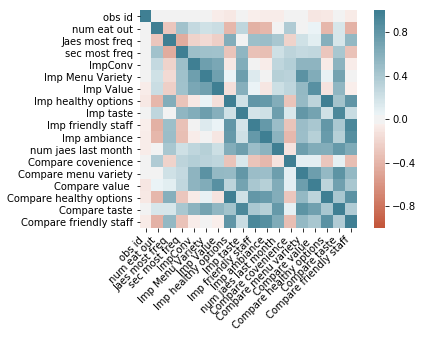

In [20]:
#draw a corrplot of customers'points in the surveyy result
#for those variable we choose having big variance but highly correlated we will drop those who has relevant smaller varianve
data=df.iloc[:,1:19]
corr = data.corr()
ax = seaborn.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=seaborn.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### The analysis of variable selection

For variable selection, I have taken out non-informative variables which can create noise in our clustering analysis, which include variables such as age or gender that are used to describe customers rather than to categorize them. I want to focus customer preferences rather than their demographics.  
Next, I picked variables with variance greater than 1.5 since the bigger the variance the better it is models to learn and predict. For variables that exhibit high collinearity amongst themselves, I chose variables with greater variance and take out the other one.  
I finalized the choice of variables with columns 'num eat out', 'ImpConv', 'Imp Menu Variety', 'num jaes last month', 'Compare convenience', 'Compare healthy options', 'Compare taste', and 'Compare friendly staff' as I aim to segment customers based on their preferences of the following aspects:  

▪ Food options (e.g. menu variety, healthy food provided or not)  
▪ Services (e.g. staff, convenience)  
▪ Eating habit (e.g. numbers of eating out)

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import FactorAnalysis
from plotnine import *

In [23]:
#So we choose the variable based on  
#One is mainly aimed at detecting the “noisy” noninformative variables, 
#while the other also deals with multicolinearity and general dependence
#vatiable we will use 
#num eat out, ImpConv, Imp Menu Variety, num jaes last month
#Compare covenience, Compare healthy options, Compare taste, Compare friendly staff
X=df.loc[:,['num eat out', 'ImpConv', 'Imp Menu Variety', 'num jaes last month', 'Compare covenience', 'Compare healthy options', 
            'Compare taste','Compare friendly staff']]

#First, we do kmeans using our chosen variable

#finding the optimal variable for k-menas
objective = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    objective.append(kmeans.inertia_)

kmeans_objectives = pd.DataFrame({'K': range(1,10), 'objective': objective})

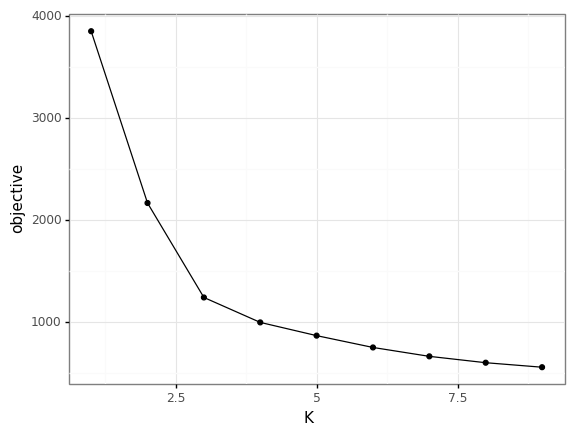

<ggplot: (-9223371902064370053)>

In [26]:
# plot the results; what K is best?
(ggplot(kmeans_objectives)     # defining what data to use
 + aes(x='K', y='objective')   # map variables to attributes
 + geom_point() + geom_line()  # defining the type of geometric objects to use
 + theme_bw()                  # other aestheic attributes
)

In [49]:
# We will use 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# append the clusters to the data
clustered_data = df.join(pd.DataFrame({'cluster': kmeans.labels_}))

In [50]:
clustered_data['cluster'].astype('category').value_counts()

0    108
2    41 
1    40 
Name: cluster, dtype: int64

In [30]:
pd.crosstab(clustered_data.cluster,[clustered_data.age])

age,1.0,2.0,3.0,4.0
cluster,,,,
0,9,48,46,5
1,4,36,0,0
2,0,1,36,4


In [31]:
pd.crosstab(clustered_data.cluster,clustered_data.income)

income,1.0,2.0,3.0,4.0
cluster,,,,
0,24,56,28,0
1,37,3,0,0
2,1,0,20,20


In [32]:
pd.crosstab(clustered_data.cluster,clustered_data.gender)

gender,1.0,2.0
cluster,,
0,86,22
1,3,37
2,37,4


In [34]:
#let notebook display all the columns
pd.set_option('display.max_columns', None)

In [35]:
clustered_data.iloc[:,2:].groupby('cluster').mean()

,num eat out,Jaes most freq,sec most freq,ImpConv,Imp Menu Variety,Imp Value,Imp healthy options,Imp taste,Imp friendly staff,Imp ambiance,num jaes last month,Compare covenience,Compare menu variety,Compare value,Compare healthy options,Compare taste,Compare friendly staff,Compare ambiance,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12
cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.796296,0.231481,0.12037,2.287037,2.157407,2.500000,1.648148,1.685185,2.101852,2.222222,1.055556,3.416667,2.157407,2.5,1.648148,1.685185,2.101852,2.222222,1.203704,2.435185,2.037037,1.787037,0.037037,0.083333,0.037037
1,4.225000,0.125000,0.87500,4.475000,4.000000,4.475000,1.525000,5.525000,2.000000,2.000000,4.525000,4.500000,4.000000,4.5,1.500000,5.500000,2.000000,1.975000,1.925000,1.900000,1.075000,1.675000,0.050000,0.050000,0.000000
2,1.878049,0.975610,0.02439,2.560976,2.536585,2.560976,5.390244,3.536585,4.439024,4.439024,5.731707,2.585366,4.024390,4.0,5.487805,4.414634,5.487805,4.439024,1.097561,3.073171,3.439024,2.902439,1.268293,0.585366,0.073171


### Custtomer Profiling
For the all three clusters, the differentiating factors across their psychographic characteristics are noted below (after profiling each against the population mean) –  

1) **Cluster 0** is the biggest cluster having close to 60% of the entire population. A lot of characteristics they exhibit is close to the entire population. In terms of going out to eat, preference towards Jae’s, convivence of going out and ambience namely. Menu variety, value, healthy options, taste, and friendliness of the staff are however is of less importance to them. In terms of comparing Jae’s against others, they rarely visit Jae (once a month whereas the population visits more than 2.5 times) and they compare Jae’s poorly against other places when it comes to – value, variety, and taste. I call them **Run-of-the-mill**.  

2) **Cluster 1** is as big as the third cluster. Cluster 1 comprises of **No-Nonsense Foodies** – people who go out more than four times a week on an average and prefers Jae’s to be their second favorite restaurant. In terms of importance to metrics – they prefer convenience, value, variety, taste and hold Jae’s in high regard in these four. They pay little or no heed to healthy options, friendly staff or ambiance.  

3) **Cluster 2** Now these are the loyal bunch at Jae’s – they hardly go out to eat but when they do, they go to Jae’s. They prefer healthy options, the importance of friendly staff and ambience. As compared to other restaurants they feel Jae’s does great when it comes to healthy options, variety, friendliness and ambiance while needing to improve its convenience. I call them **The Loyalists**.  


### FA before clustering

In [37]:
# Define a helper function to sort attibutes
def sorted_attr(idx, cluster_centers, column_names):
    print("*** Sorted attributes for %d ***" % idx)
    for i in sorted(range(len(column_names)), key=lambda i: -cluster_centers[idx,i]):
        print(column_names[i], cluster_centers[idx,i])

In [74]:
df.head()

,index,obs id,num eat out,Jaes most freq,sec most freq,ImpConv,Imp Menu Variety,Imp Value,Imp healthy options,Imp taste,Imp friendly staff,Imp ambiance,num jaes last month,Compare covenience,Compare menu variety,Compare value,Compare healthy options,Compare taste,Compare friendly staff,Compare ambiance,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12
0,1,292,4,0,1,5.0,4.0,5.0,1.0,5.0,2.0,2.0,4.0,5.0,4.0,5.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,2,306,4,0,1,4.0,4.0,4.0,2.0,6.0,2.0,2.0,5.0,4.0,4.0,4.0,2.0,6.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0
2,3,314,2,1,0,3.0,3.0,3.0,6.0,3.0,5.0,4.0,5.0,3.0,4.0,4.0,6.0,5.0,5.0,4.0,2.0,3.0,3.0,3.0,2.0,0.0,0.0
3,4,332,2,1,0,2.0,2.0,2.0,5.0,4.0,4.0,5.0,7.0,2.0,4.0,4.0,5.0,4.0,6.0,5.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0
4,5,346,2,0,0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,1.0,2.0,3.0,2.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,0.0,0.0,0.0


In [78]:
X1=df.iloc[:,2:20]

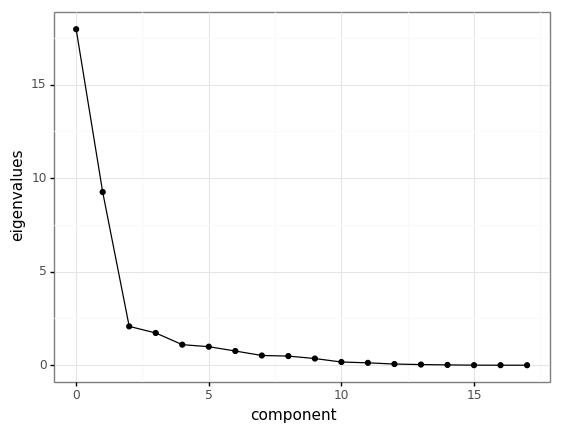

<ggplot: (134790958607)>

In [79]:
# scree plot
from sklearn.decomposition import PCA
pca = PCA().fit(X1)
scree_data = pd.DataFrame({'eigenvalues': pca.explained_variance_, 
                           'component': range(len(pca.explained_variance_))})
# plot the results; what K is best?
(ggplot(scree_data)                      # defining what data to use
 + aes(x='component', y='eigenvalues')   # map variables to attributes
 + geom_point() + geom_line()            # defining the type of geometric objects to use
 + theme_bw()                            # other aestheic attributes
)

In [81]:
# Now let's try something else...running factor analysis on our attributes
transformer = FactorAnalysis(n_components=2, random_state=0)
X_transformed = pd.DataFrame(transformer.fit_transform(X1))
transformer.components_

array([[ 0.24327389, -0.21100858, -0.0182521 , -0.4061628 , -0.50765851,
        -0.36801961, -1.35232648, -1.15625216, -0.97444729, -0.93124463,
        -1.85356319,  0.22737535, -0.98546996, -0.84321537, -1.35997501,
        -1.44663066, -1.3058609 , -0.93017817],
       [ 0.77196969, -0.21297505,  0.3217047 ,  0.82504467,  0.72000742,
         0.80534073, -0.80903148,  1.12248598, -0.56654707, -0.59742852,
         0.31378859,  0.66983988,  0.41049569,  0.49743154, -0.80285899,
         0.9189717 , -0.77899045, -0.60746356]])

In [82]:
# What's important to each factor?
sorted_attr(0, transformer.components_, X1.columns)
sorted_attr(1, transformer.components_, X1.columns)

*** Sorted attributes for 0 ***
num eat out 0.24327388868633434
Compare covenience 0.2273753483042114
sec most freq -0.01825210322336436
Jaes most freq -0.21100858109062612
Imp Value -0.36801960663043964
ImpConv -0.40616279930783095
Imp Menu Variety -0.5076585145537345
Compare value  -0.8432153659570122
Compare ambiance -0.9301781705234957
Imp ambiance -0.9312446325335536
Imp friendly staff -0.9744472901321821
Compare menu variety -0.9854699612681757
Imp taste -1.156252156823764
Compare friendly staff -1.3058609049879404
Imp healthy options -1.352326481859949
Compare healthy options -1.359975013357667
Compare taste -1.4466306638191546
num jaes last month -1.8535631907334682
*** Sorted attributes for 1 ***
Imp taste 1.1224859845958741
Compare taste 0.9189717021972582
ImpConv 0.825044668494998
Imp Value 0.8053407349843427
num eat out 0.7719696864170366
Imp Menu Variety 0.7200074235674013
Compare covenience 0.6698398769513787
Compare value  0.4974315449523641
Compare menu variety 0.410495

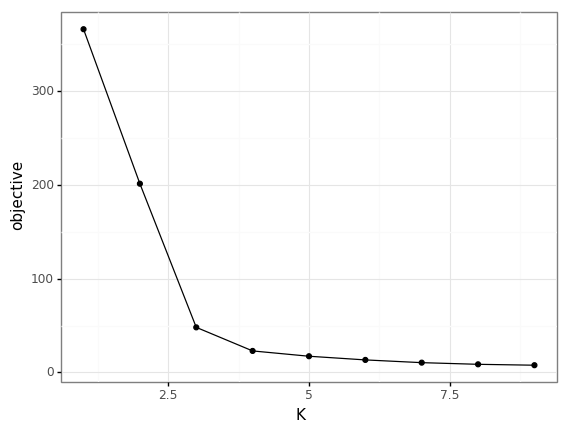

<ggplot: (-9223371902063747605)>

In [83]:
# Let's cluster based on the FA scores

# Loop over several values of K
objective = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_transformed)
    objective.append(kmeans.inertia_)

kmeans_objectives = pd.DataFrame({'K': range(1,10), 'objective': objective})

# plot the results; what K is best?
(ggplot(kmeans_objectives)     # defining what data to use
 + aes(x='K', y='objective')   # map variables to attributes
 + geom_point() + geom_line()  # defining the type of geometric objects to use
 + theme_bw()                  # other aestheic attributes
)

In [84]:
# We will use 3 clusters
kmeans1 = KMeans(n_clusters=3, random_state=0).fit(X_transformed)
# append the clusters to the data
clustered_data1 = df.join(pd.DataFrame({'cluster': kmeans1.labels_}))

In [85]:
clustered_data1['cluster'].astype('category').value_counts()

2    108
1    41 
0    40 
Name: cluster, dtype: int64

In [86]:
#means of clusters 
#KMEANS ON FA RESULT
round(clustered_data1.iloc[:,2:].groupby('cluster').mean(),3)

,num eat out,Jaes most freq,sec most freq,ImpConv,Imp Menu Variety,Imp Value,Imp healthy options,Imp taste,Imp friendly staff,Imp ambiance,num jaes last month,Compare covenience,Compare menu variety,Compare value,Compare healthy options,Compare taste,Compare friendly staff,Compare ambiance,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12
cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.825,1.000,0.000,2.500,2.500,2.500,5.500,3.500,4.500,4.500,5.775,2.500,4.000,4.000,5.500,4.500,5.500,4.500,1.075,3.100,3.500,2.950,1.300,0.600,0.075
1,4.220,0.122,0.878,4.488,4.000,4.488,1.512,5.512,2.000,2.000,4.512,4.537,4.024,4.488,1.585,5.390,2.073,1.976,1.927,1.902,1.073,1.659,0.049,0.049,0.000
2,2.796,0.231,0.120,2.287,2.157,2.500,1.648,1.685,2.102,2.222,1.056,3.417,2.157,2.500,1.648,1.685,2.102,2.222,1.204,2.435,2.037,1.787,0.037,0.083,0.037


In [87]:
#means of clusters 
#KMEANS ON CHOSEN VARIABLE
round(clustered_data.iloc[:,2:].groupby('cluster').mean(),3)

,num eat out,Jaes most freq,sec most freq,ImpConv,Imp Menu Variety,Imp Value,Imp healthy options,Imp taste,Imp friendly staff,Imp ambiance,num jaes last month,Compare covenience,Compare menu variety,Compare value,Compare healthy options,Compare taste,Compare friendly staff,Compare ambiance,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12
cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.796,0.231,0.120,2.287,2.157,2.500,1.648,1.685,2.102,2.222,1.056,3.417,2.157,2.5,1.648,1.685,2.102,2.222,1.204,2.435,2.037,1.787,0.037,0.083,0.037
1,4.225,0.125,0.875,4.475,4.000,4.475,1.525,5.525,2.000,2.000,4.525,4.500,4.000,4.5,1.500,5.500,2.000,1.975,1.925,1.900,1.075,1.675,0.050,0.050,0.000
2,1.878,0.976,0.024,2.561,2.537,2.561,5.390,3.537,4.439,4.439,5.732,2.585,4.024,4.0,5.488,4.415,5.488,4.439,1.098,3.073,3.439,2.902,1.268,0.585,0.073


### At some point, you will also need to use the noncustomer survey data...
Note: the simplest approach in this phase of your analysis will be to use crosstabs on the noncustomer survey data.

In [88]:
noncustomer_survey = pd.read_csv("NoncustomerSurvey.tsv", sep ='\t', header=1)

In [89]:
# pull out the column descriptions
noncustomer_descriptions = noncustomer_survey.loc[0,]
noncustomer_descriptions

obs                               Observation Identifier                                                                                                                                               
#times/wk eat lunch/dinner out    Actual number of times per week that respondent eats lunch or dinner out                                                                                             
FCR most freq                     Question asked for the name of the respondent's favorite restaurant - if the response was Ja Fast Casual Restaurant it is coded as a 1, if it was not, it is a 0.    
FCR sec most freq                 Question asked for the name of the respondent's 2nd favorite restaurant - if the response was Ja Fast Casual Restaurant it is coded as a 1, if it was not, it is a 0.
Imp convenient                    How important is convenience to you in your selection of a restaurant at which to eat?  1= Not at All Important to 6=Very important                                  


In [104]:
# remove descriptions for clean data
noncustomer_df = noncustomer_survey.drop(0)

# turn the data into numbers and non-responses into NaN
def isnumber(x):
    try:
        int(x)
        return True
    except:
        return False

noncustomer_df = noncustomer_df[noncustomer_df.applymap(isnumber)]
noncustomer_df = noncustomer_df.apply(pd.to_numeric)
noncustomer_df =noncustomer_df.drop(noncustomer_df.iloc[:,-7:], axis = 1) 
#noncustomer_df = noncustomer_df.dropna()
#len(noncustomer_df)
noncustomer_df

,obs,#times/wk eat lunch/dinner out,FCR most freq,FCR sec most freq,Imp convenient,Imp menu variety,Imp value,Imp healty options,Imp taste,Imp friendly staff,Imp ambience,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12,area
1,5,5.0,0.0,0.0,4,5.0,5,2.0,6,2.0,1,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1
2,12,3.0,0.0,0.0,5,3.0,4,1.0,5,2.0,3,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1
3,17,6.0,1.0,0.0,4,3.0,5,1.0,4,2.0,2,2.0,2.0,2.0,2.0,0.0,0.0,0.0,1
4,29,1.0,0.0,0.0,2,2.0,2,6.0,3,4.0,4,1.0,3.0,3.0,3.0,2.0,0.0,0.0,2
5,105,1.0,1.0,1.0,3,2.0,2,5.0,4,5.0,3,1.0,3.0,3.0,3.0,1.0,1.0,0.0,2
6,107,2.0,1.0,1.0,2,3.0,3,6.0,4,5.0,5,1.0,2.0,4.0,3.0,0.0,1.0,1.0,2
7,124,1.0,1.0,1.0,1,2.0,1,2.0,1,2.0,2,1.0,3.0,1.0,2.0,0.0,1.0,0.0,1
8,134,2.0,1.0,1.0,2,3.0,2,5.0,3,5.0,5,1.0,2.0,3.0,2.0,0.0,0.0,0.0,2
9,135,1.0,0.0,NaN,1,1.0,1,1.0,1,1.0,1,1.0,2.0,1.0,2.0,0.0,0.0,0.0,1
10,140,1.0,NaN,NaN,2,1.0,1,2.0,1,1.0,2,1.0,3.0,1.0,2.0,0.0,0.0,0.0,2


In [109]:
#Area:  1= Chapel Hill, 2=Southpoint

noncustomer_area1=noncustomer_df[noncustomer_df['area']==1]
noncustomer_area2=noncustomer_df[noncustomer_df['area']==2]

In [110]:
noncustomer_area1.describe()

,obs,#times/wk eat lunch/dinner out,FCR most freq,FCR sec most freq,Imp convenient,Imp menu variety,Imp value,Imp healty options,Imp taste,Imp friendly staff,Imp ambience,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12,area
count,90.000000,88.000000,71.000000,68.000000,90.000000,89.000000,90.000000,89.000000,90.000000,89.000000,90.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,90.0
mean,132.422222,3.500000,0.535211,0.544118,3.411111,2.943820,3.455556,1.494382,3.666667,1.786517,1.844444,1.693182,2.011364,1.375000,1.477273,0.079545,0.068182,0.090909,1.0
std,74.019277,1.941678,0.502309,0.501753,1.452580,1.334503,1.690430,0.676280,1.977400,0.412088,0.791970,0.463816,0.837269,0.573605,0.606048,0.346463,0.332025,0.470665,0.0
min,4.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,64.250000,1.000000,0.000000,0.000000,2.000000,2.000000,1.250000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
50%,137.000000,3.000000,1.000000,1.000000,4.000000,3.000000,4.000000,1.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
75%,191.500000,5.000000,1.000000,1.000000,4.000000,3.000000,5.000000,2.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.0
max,264.000000,6.000000,1.000000,1.000000,6.000000,5.000000,5.000000,5.000000,6.000000,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,2.000000,2.000000,4.000000,1.0


In [114]:
#Gender:  1= Female, 2=Male
#Age:  1=Under 20, 2=20–30, 3=31–40, 4=40-65, 5=65+
#Income:  1=Under $35,000, 2=$35,000–$50,000, 3= $50,000-$100,000, 4=$100,000+
#Hhld type:  1=Single, 2=Couple, 3=Family
#number of kids under 5
#number of kids between 5 and 12
#number of kids over 12

noncustomer_area1.iloc[:,-8:].apply(pd.value_counts)

,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12,area
0.0,NaN,NaN,NaN,NaN,83.0,84.0,83.0,NaN
1.0,27.0,24.0,59.0,51.0,3.0,2.0,4.0,90.0
2.0,61.0,45.0,25.0,32.0,2.0,2.0,NaN,NaN
3.0,NaN,13.0,4.0,5.0,NaN,NaN,NaN,NaN
4.0,NaN,6.0,NaN,NaN,NaN,NaN,1.0,NaN


In [ ]:
#Gender:  1= Female, 2=Male
#Age:  1=Under 20, 2=20–30, 3=31–40, 4=40-65, 5=65+
#Income:  1=Under $35,000, 2=$35,000–$50,000, 3= $50,000-$100,000, 4=$100,000+
#Hhld type:  1=Single, 2=Couple, 3=Family
#number of kids under 5
#number of kids between 5 and 12
#number of kids over 12

noncustomer_area2.iloc[:,-8:].apply(pd.value_counts)

In [107]:
noncustomer_area2.describe()

,obs,#times/wk eat lunch/dinner out,FCR most freq,FCR sec most freq,Imp convenient,Imp menu variety,Imp value,Imp healty options,Imp taste,Imp friendly staff,Imp ambience,gender,age,income,hhld type,kids under 5,kids 5-12,kids over 12,area,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
count,90.000000,88.000000,68.000000,61.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,88.000000,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,141.811111,1.500000,0.602941,0.524590,2.144444,2.155556,2.066667,4.377778,2.855556,3.711111,3.288889,1.089888,2.595506,2.662921,2.606742,0.730337,0.494382,0.375000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,73.535728,1.093345,0.492926,0.503539,0.679741,0.763068,0.871522,1.881774,1.353822,1.623178,1.384054,0.287641,0.669449,1.065405,0.684537,0.822469,0.502801,0.699959,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,81.750000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,137.500000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,5.000000,3.000000,4.000000,3.000000,1.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,204.000000,2.000000,1.000000,1.000000,3.000000,3.000000,2.750000,6.000000,4.000000,5.000000,4.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,266.000000,7.000000,1.000000,1.000000,4.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,4.000000,4.000000,3.000000,2.000000,1.000000,4.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### FINAL RECOMMENDATION

   Based on EDA and clustering on Jae’s existing customers, and EDA of residents divided by two different areas choice, we identified that The Loyalists are very similar to the ones that live in **Southpoint (area 2)** – both in terms of demographics and psychographics.  
   
   They are wealthy females with families (Jae’s Loyalists segment from the existing base) and already prefer Jae’s as their first choice. Opening an outlet closer to their home will not only improve the NPS but also get more footfall from other similar customers in the Southpoint area.  
   
  People around the Southpoint area also prefer healthy options (Jae’s USP), friendly staff, and ambience a lot more than their Chapel Hill counterparts.  
  
  Although Southpoint seems to be a better location to open Jae’s second outlet, I recommend running analysis on how much of Jae’s Ninth street outlet’s footfall will be cannibalized. 